In [200]:
import torch
import torchvision
from torchvision import transforms, datasets

In [201]:
torch.cuda.init()
enable_cuda = False
is_cuda_available = torch.cuda.is_available()
use_cuda = is_cuda_available and enable_cuda

print(f"CUDA Device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
print(f"Use CUDA: {use_cuda}")

train = datasets.MNIST("", train=True, download=True,
                       transform = transforms.Compose(
                           [transforms.ToTensor()]))

test = datasets.MNIST("", train=False, download=True,
                       transform = transforms.Compose(
                           [transforms.ToTensor()]))

CUDA Device: GeForce GTX 1050
Use CUDA: False


In [202]:
trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)

In [203]:
for data in trainset:
    print(data)
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

In [204]:
x, y = data[0][0], data[1][0]

print(y)

tensor(3)


torch.Size([1, 28, 28])


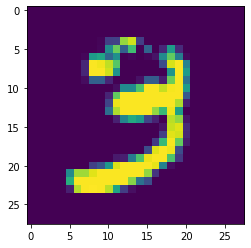

In [205]:
import matplotlib.pyplot as plt

print(data[0][0].shape)
plt.imshow(data[0][0].view(28, 28))

In [206]:
total = 0
counter_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0,
                7:0, 8:0, 9:0}

for data in trainset:
    Xs, ys = data
    for y in ys:
        counter_dict[int(y)] += 1
        total +=1
print(counter_dict)

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


In [207]:
for i in counter_dict:
    print(f"{i}: {counter_dict[i]/total*100}")

0: 9.871666666666666
1: 11.236666666666666
2: 9.93
3: 10.218333333333334
4: 9.736666666666666
5: 9.035
6: 9.863333333333333
7: 10.441666666666666
8: 9.751666666666667
9: 9.915000000000001


In [208]:
import torch.nn as nn
import torch.nn.functional as F

In [209]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 64) # fc=fully connected
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
    
    def forward(self, x):
        x = F.relu(self.fc1(x)) #Rectified Linear
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)


net = Net()
if use_cuda:
    net = net.cuda()

print(net)

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [210]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001) # lr=learning rate

EPOCHS = 2
for epoch in range(EPOCHS):
    for data in trainset:
        X, y = data # data = featuresets and labels
        net.zero_grad()
        if use_cuda:
            X, y = X.cuda(), y.cuda()

        output = net(X.view(-1, 28*28))
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
    print(loss)


tensor(0.0110, grad_fn=<NllLossBackward>)
tensor(0.0041, grad_fn=<NllLossBackward>)
tensor(0.2175, grad_fn=<NllLossBackward>)


In [211]:
correct = 0
total = 0

with torch.no_grad():
    for data in testset:
        X, y = data
        if use_cuda:
            X, y = X.cuda(), y.cuda()
        output = net(X.view(-1, 28*28))
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct +=1
            total +=1

print("Accuracy: ", round(correct/total, 3))

Accuracy:  0.964


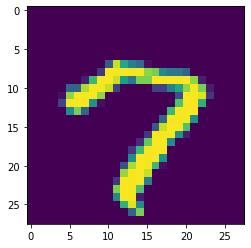

tensor(7)


In [212]:
import matplotlib.pyplot as plt

if use_cuda:
    X = X.cpu()
    net = net.cpu()

plt.imshow(X[3].view(28,28))
plt.show()
print(torch.argmax(net(X[3].view(-1, 28*28))[0]))